# Assignment 3 - Tumor segmentation with uncertainties

### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For radiotherapy treatment, often multiple contrasts are acquired of the same anatomy to have more information for organ delineations. These contrasts have been explored in the previous assignment, and now, your task is to automate the organ delineation! The model to design and train might take any number of image contrasts as an input, and outputs a tumor segmentation. For this task, you will implement and use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate (aim for a Dice score higher than $0.8$ on the validation set).

For machine learning solutions to be reliable in real life scenarios, we may want to improve their explainability. Ideally, models should not only provide their predictions, but provide a motivation for them as well. One form of explainability is through uncertainty metrics, that evaluate how certain layers, and certain nodes affect the output predictions. A popular approach is called *Monte Carlo Dropout*, where during inference, output predictions are generated multiple times using differently initialized dropout layers, therefore the individual predictions will depend on different subsets of the layers' activations. The standard deviation in the generated outputs provides insight into the model's uncertainty about the individual pixels of the predictions, in our case, the segmentations.

Your task is to look through the highly customizable code below, which contains all the main steps for automated image segmentation from using only one contrast as an input. By changing the arrays of the DataGenerator, multiple contrasts can be added as input, similar as in the previous assignmnets. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the report, are:
- How you reached the required performances (a Dice score above $0.8$)
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Once you have reached the required loss on the validation data, only then evaluate your model on the testing data as well.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.
- Using the already implemented Monte Carlo Dropout model, explore the uncertainty of the predictions on the testing data.
- How does your estimated uncertainty depend on the dropout-rates used in the model?
- Look at the uncertainty of each image in the testing dataset. Do you see anything unusual in their values? If so explore the images!

Upload the updated notebook to Canvas by June $2^{nd}$ at 17:00.

Good luck and have fun!

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random

random.seed(2023)

import numpy as np

np.random.seed(2023)  # Set seed for reproducibility
import keras
import tensorflow as tf
from tqdm import tqdm

tf.random.set_seed(2023)
tf.config.run_functions_eagerly(True)
keras.backend.clear_session()
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.models import load_model
from keras.optimizers import Adam


from archs.segmentation.unet import build_unet
from data.augmentor import Augmentor
from data.data_generator import DataGenerator, DataGeneratorAugmented
from uncertainty.monte_carlo_dropout import ModelWithMonteCarlo
from utils.callbacks import PlotMetricsCallback, PlotSampleCallback
from utils.helper import create_dirs
from utils.loss import FocalDiceLoss, dice_coef
from utils.visualizations import plot_sample

gen_dir = "./data/"
fp16 = True
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
    if fp16:
        details = tf.config.experimental.get_device_details(gpus[0])
        compute_capability = details.get('compute_capability')
        print("Compute capability:", compute_capability)
        if compute_capability[0] > 6:
            print("Turning on mixed_float16")
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU(s) available. Training will be suuuuper slow!")


GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!
Compute capability: (8, 6)
Turning on mixed_float16
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


## Training initialization

In [2]:
array_labels = ['t1', 't1ce', 't2', 'flair', 'mask']
model_name = "unet"
model_dir, figure_path, checkpoint_path = create_dirs(model_name)
batch_size = 8
epochs = 20
augment = True

In [3]:
# Augmentator
augmentor = Augmentor(translate=0, # No translation. Due to lack of speed.
                      shear=0, # No shear. Due to lack of speed.
                      rotate=0, # No rotation. Due to lack of speed.
                      mask=0.8, # Probability of masking the image.
                      mask_size=0.2, # Maximum size of the mask as a fraction of the image size.
                      max_n_masks=6, # Maximum number of masks to apply.
                      noise=0.4, # Probability of adding Gaussian noise to the image.
                      noise_mean=0.05, # Mean of the noise.
                      noise_std=0.1, # Standard deviation of the noise.
                      ) if augment else None# Augmentation of the data.
# Data generators
gen_train = DataGeneratorAugmented(data_path=gen_dir + 'training',
                          array_labels=array_labels,
                          batch_size=batch_size,
                          augmentor=augmentor)
gen_val = DataGeneratorAugmented(data_path=gen_dir + 'validating',
                        array_labels=array_labels,
                        batch_size=batch_size)
gen_test = DataGeneratorAugmented(data_path=gen_dir + 'testing',
                         array_labels=array_labels,
                         batch_size=batch_size)

In [4]:
input_shape = (64,64,len(array_labels)-1)
num_classes = 1 # Number of classes is equal to the number of channels in the output
filters = [8,16,32,64,128,256]
kernel_size = 3
strides = 1
padding = "same"
activation = "relu"
drop_rate_encoder = [0.01, 0.2, 0.2, 0.1, 0]
drop_rate_decoder = [0.0,0.0,0]
depth_encoder = [1,1,2,3]#[3,3,4,5]
depth_decoder = [2,1,1,0]#[3,2,1,1,0]
output_depth = 2
output_activation = "sigmoid"

loss = FocalDiceLoss(w_focal=2.0, w_dice=0.5)
optimizer = Adam(learning_rate=1e-3)

In [5]:
unet = build_unet(
            input_shape=input_shape,
            num_classes=num_classes,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=activation,
            depth_encoder=depth_encoder,
            depth_decoder=depth_decoder,
            drop_rate_encoder=drop_rate_encoder,
            drop_rate_decoder=drop_rate_decoder,
            output_depth=output_depth,
            output_activation=output_activation,
            decoder_type="add",
            upsample_type="bilinear",
        )

Filters: 6, kernel_size: 6, strides: 6, padding: 6, activation: 6, depth: 6, drop_rate: 6


In [8]:
keras.models.Model(inputs=unet.inputs, outputs=unet.outputs).summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 32, 32, 8),  4351520     ['input_2[0][0]']                
                                 (None, 16, 16, 16)                                               
                                , (None, 8, 8, 32),                                               
                                 (None, 4, 4, 64),                                                
                                 (None, 2, 2, 128),                                               
                                 (None, 1, 1, 256)]                                         

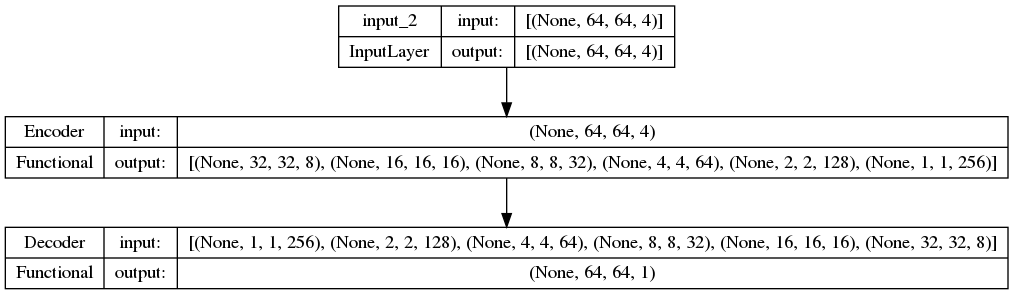

In [6]:
plot_model(unet, to_file=os.path.join(figure_path, "unet.png"), show_shapes=True, show_layer_names=True)

In [7]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 32, 32, 8),  4351520     ['input_2[0][0]']                
                                 (None, 16, 16, 16)                                               
                                , (None, 8, 8, 32),                                               
                                 (None, 4, 4, 64),                                                
                                 (None, 2, 2, 128),                                               
                                 (None, 1, 1, 256)]                                           

/home/theodor/Code/AppliedDL-project/data/data_generator.py:80: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
/home/theodor/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


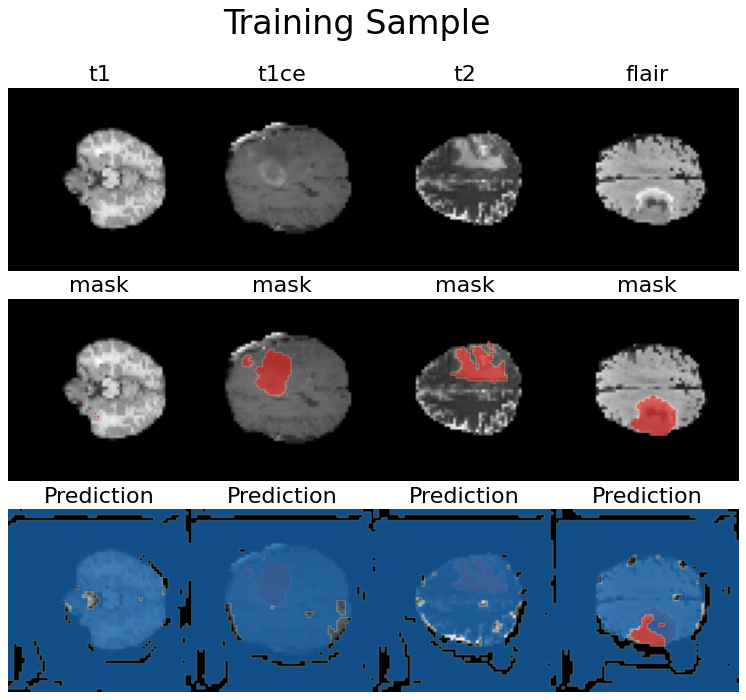

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min')
plot_metrics_callback = PlotMetricsCallback(epochs=epochs,n_batches=len(gen_train))
plot_sample_callback = PlotSampleCallback(gen_val, figure_path, threshold=0.5, title=f"Validation sample")
callbacks = [early_stopping, reduce_lr, plot_metrics_callback, plot_sample_callback]

unet.compile(loss=loss, metrics=dice_coef, optimizer=optimizer)

plot_sample(gen_val, array_labels, model=unet, batch_idx=2, save=False, title=f"Training Sample")

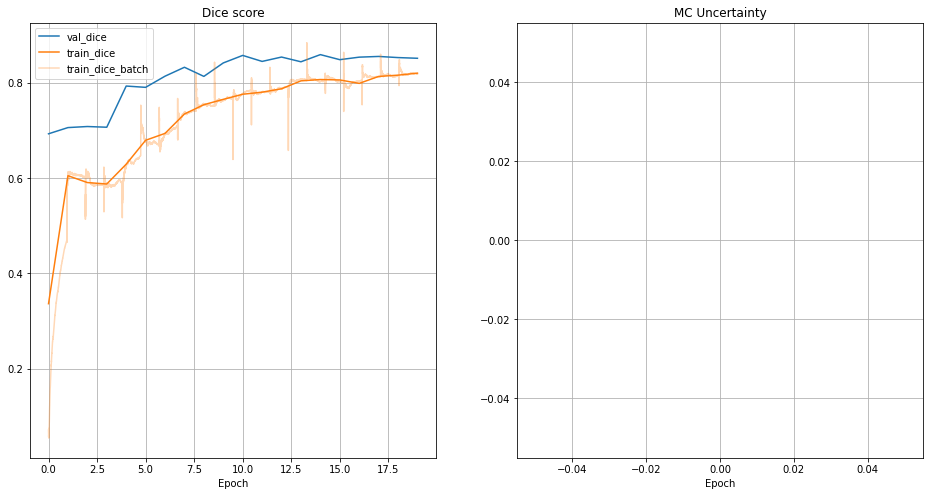

1000/1000 [==============================] - 231s 231ms/step - loss: 0.1297 - dice_coef: 0.8194 - val_loss: 0.1084 - val_dice_coef: 0.8523 - lr: 1.2500e-04
Epoch 20: early stopping


In [9]:
history = unet.fit(gen_train, epochs=epochs, validation_data=gen_val, verbose=1, callbacks=callbacks)

In [12]:
unet.evaluate(gen_val)

/home/theodor/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/theodor/Code/AppliedDL-project/data/data_generator.py:80: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


125/125 [==============================] - 13s 105ms/step - loss: 0.1036 - dice_coef: 0.8574


[0.10362597554922104, 0.8573841452598572]

### Let's plot some example images from the dataset:

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = len(gen_train.arrays), 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

imgs = gen_train[0]
idx = np.random.randint(0, np.shape(gen_train[0][0])[0], 5)
ii = 0
for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[i][idx[ii], :, :, 0], cmap='gray', vmin=0, vmax=1)

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

AttributeError: 'DataGeneratorAugmented' object has no attribute 'arrays'

<Figure size 1152x576 with 0 Axes>

### There's a chance, that the bottom row only shows black images, in that case, all four examples are from slices that don't have masks.

A quick summary of the data:

In [ ]:
%%skip True
# A quick summary of the data:

print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")
found_masks = 0
for idx, (img) in enumerate(gen_val): # Add the additional inputs inside the brackets
    mask = img[-1]
    found_masks += np.sum(np.sum(mask > 0, (1, 2, 3)) > 0)
print(f"The percentage of slices that contain masks : {np.round(100 * (found_masks / (len(gen_val) * batch_size)), 2)}%")

UsageError: Cell magic `%%skip` not found.


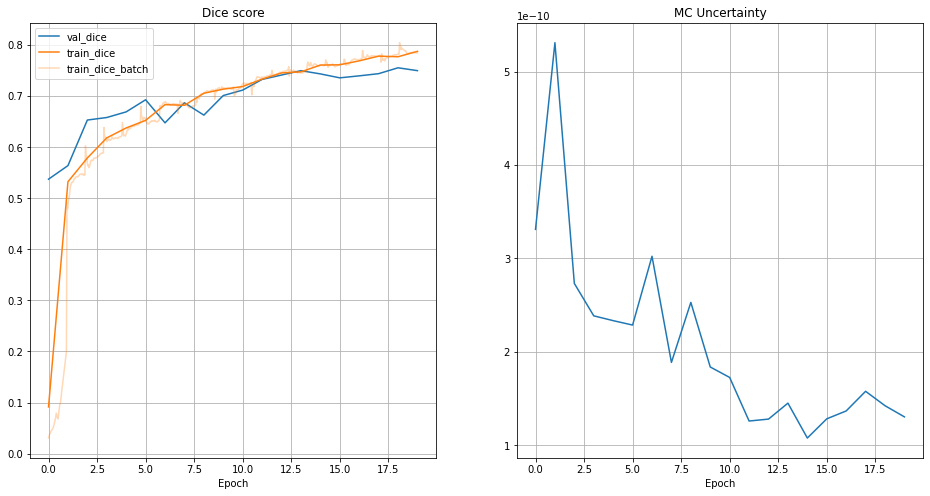

31/31 [==============================] - 71s 2s/step - loss: 0.1076 - dice_coef: 0.7849 - monte_carlo_uncertainty: 0.0000e+00 - val_loss: 0.1250 - val_dice_coef: 0.7500 - val_monte_carlo_uncertainty: 1.3052e-10 - lr: 0.0025


In [ ]:
history = generator.fit(gen_train, epochs=epochs, validation_data=gen_val, verbose=1, callbacks=callbacks)

In [ ]:
results = generator.evaluate(gen_test, return_dict=True)
dice = results["dice_coef"]
uncertainty = results["monte_carlo_uncertainty"]
print(f"Dice score: {dice:.2e}")
print(f"Uncertainty: {uncertainty:.2e}")

1/3 [=========>....................] - ETA: 4s - loss: 0.2056 - dice_coef: 0.5887 - monte_carlo_uncertainty: 8.9846e-11

/tmp/ipykernel_11707/91355230.py:65: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


3/3 [==============================] - 6s 2s/step - loss: 0.1985 - dice_coef: 0.6030 - monte_carlo_uncertainty: 9.8073e-11
Dice score: 6.03e-01
Uncertainty: 9.81e-11


/home/theodor/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


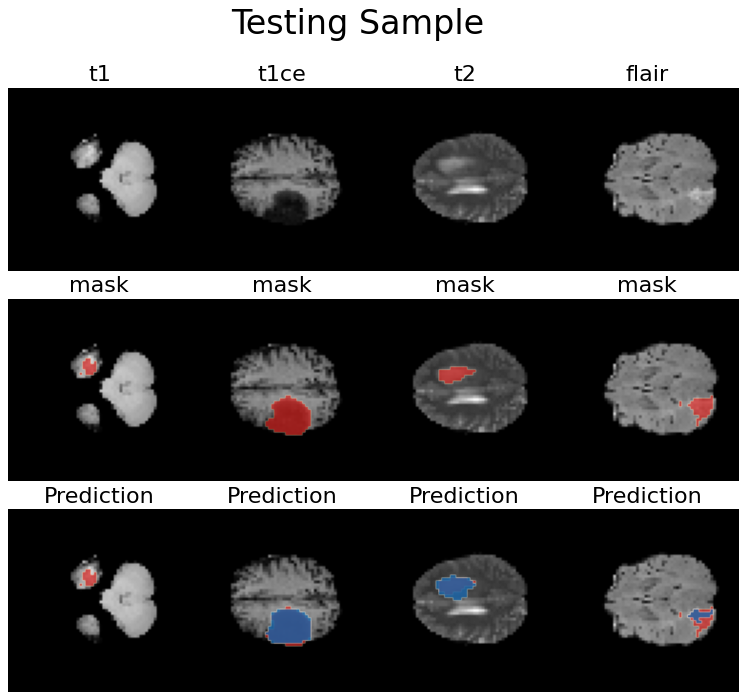

In [ ]:
plot_sample(gen_val, array_labels, model=generator, batch_idx=None, save=False, title=f"Testing Sample")

In [ ]:
generator.save(checkpoint_path)

INFO:tensorflow:Assets written to: models/unet_focal/checkpoints/assets


INFO:tensorflow:Assets written to: models/unet_focal/checkpoints/assets


In [ ]:
# gen2 = load_model(checkpoint_path, custom_objects={'MonteCarloDropoutModel': MonteCarloDropoutModel, 'dice_coef': dice_coef, 'ModelWithMonteCarlo': ModelWithMonteCarlo, 'FocalDiceLoss': FocalDiceLoss}, compile=False)

Epoch 14, Dice score: 0.7371. Diff: -0.0013
Epoch 14, validation uncertainty: 0.0026. Diff: 0.0000


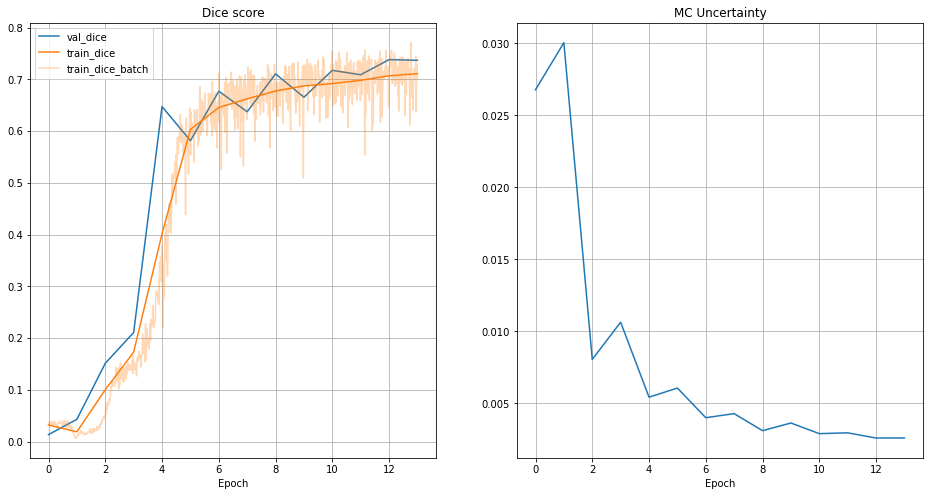

4/4 [==============================] - 0s 3ms/step


Train Epoch 15/20:   0%|          | 0/62 [00:00<?, ?it/s]/tmp/ipykernel_32529/730934060.py:65: RuntimeWarning: invalid value encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Train Epoch 15/20:   6%|▋         | 4/62 [00:04<01:04,  1.11s/it]

In [ ]:
n_epochs = 20
prev_dice_score = 0
prev_unc = 0
plot_validating_dice = []
plot_training_dice = []
plot_validating_unc = []
best_dice_score = 0
batches_seen = 0
training_loss = []
n_batches = len(gen_train)
for epoch in range(n_epochs):
    validating_loss = []
    validating_unc = []
    plot_sample(gen_val, array_labels, model=generator, threshold=0.3, save=True, title=f"Validation sample epoch {epoch}", save_path=figure_path, figure_name=f"val_epoch_{epoch}.png")
    pbar = tqdm(total=len(gen_train), desc='Train Epoch %d/%d' % (epoch + 1, n_epochs))
    for idx, (inputs, mask) in enumerate(gen_train): # Add the additional inputs inside the brackets
        pbar.update(1)
        h = generator.train_on_batch(inputs, mask)
        training_loss.append(h[-1])
        batches_seen += 1
    pbar.close()
    plot_training_dice.append(np.mean(training_loss[n_batches*epoch:n_batches*(epoch+1)]))
    pbar = tqdm(total=len(gen_val), desc='Val Epoch %d/%d' % (epoch + 1, n_epochs))
    for idx, (inputs, mask) in enumerate(gen_val): # Add the additional inputs inside the brackets
        pbar.update(1)
        validating_loss.append(generator.test_on_batch(inputs, mask)[1])
        validating_unc.append(np.mean(generator_MCunc.predict(inputs).numpy()))
    pbar.close()
    plot_validating_dice.append(np.mean(validating_loss))
    plot_validating_unc.append(np.mean(validating_unc))
    
    val_dice = np.mean(validating_loss)
    val_unc = np.mean(validating_unc)
    diff_dice = val_dice - prev_dice_score
    diff_unc = val_unc - prev_unc
    prev_dice_score = val_dice
    prev_unc = val_unc
    if val_dice > best_dice_score:
        best_dice_score = val_dice
        path = os.path.join(checkpoint_path, f"best_dice_score")
        generator.save(path)
    if epoch % 5 == 0:
        path = os.path.join(checkpoint_path, f"epoch_{epoch}")
        generator.save(path)
    clear_output(wait=True)
    print(f"Epoch {epoch+1}, Dice score: {val_dice:.4f}. Diff: {diff_dice:.4f}")
    print(f"Epoch {epoch+1}, validation uncertainty: {val_unc:.4f}. Diff: {diff_unc:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_validating_dice, label="val_dice")
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_training_dice, label="train_dice",color='C1')
    axs[0].plot(np.linspace(0, epoch, batches_seen), training_loss, label="train_dice_batch", alpha=0.3, color='C1')
    axs[0].legend()
    axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_validating_unc, label="val_unc")
    axs[0].set_title("Dice score")
    axs[0].grid(True)
    axs[0].set_xlabel('Epoch')
    axs[1].set_title("MC Uncertainty")
    axs[1].grid(True)
    axs[1].set_xlabel('Epoch')
    # Second Row - Display some predictions
    plt.show()
    
    # if (np.mean(validating_loss) < 0.015):
    #     break

# NOTE: When should training stop? How long did it take to reach the required DICE score?
# NOTE: Describe what behavior you expect from the two plots?
# NOTE: Detail what outcomes you have faced when the training failed? Why do you think that happened? How did you try to fix it?

In [ ]:
data = gen_val[np.random.randint(0, len(gen_val))] # Add the additional inputs
inputs, mask = pre_prosses(data)
prediction = generator.predict(inputs)
# uncertainty = generator_MCunc.predict(inputs)
uncertainty = generator.monte_carlo_model.predict(inputs)
plt.figure(figsize=(8, 16))
fig, axs = plt.subplots(5, 4)
%matplotlib qt
for idx in range(5):
    plt.subplot(5, 4, idx * 4 + 1)
    plt.imshow(inputs[idx,:,:,-2].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Image', fontsize=22)
    plt.subplot(5, 4, idx * 4 + 2)
    plt.imshow(inputs[idx,:,:,-2].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('GT', fontsize=22)
    plt.subplot(5, 4, idx * 4 + 3)
    plt.imshow(prediction[idx, :, :].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('PRED', fontsize=22)
    plt.subplot(5, 4, idx * 4 + 4)
    plt.imshow(uncertainty[idx, :, :].squeeze(), cmap='Reds', vmin=0, vmax=np.max(uncertainty))
    plt.colorbar()
    plt.title('MC-uncertainty', fontsize=22)

# NOTE: How good do the images look like? What do you think is needed for better results?
# NOTE: Discuss the difference between false positives and false negatives in the segmentations.
# NOTE: Discuss the uncertainties. Where is it large, where is it small? Why? Is this what you would expect?

8/8 [==============================] - 0s 14ms/step


/home/theodor/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
model:Model = load_model(os.path.join(checkpoint_path, "best_dice_score"),custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss},compile=False)
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])
model.evaluate(gen_val)

/tmp/ipykernel_652/730934060.py:65: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


7/7 [==============================] - 7s 1s/step - loss: 0.3010 - dice_coef: 0.6990


[0.300979882478714, 0.6990200877189636]

In [ ]:
model.evaluate(gen_test)

/tmp/ipykernel_652/730934060.py:65: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


7/7 [==============================] - 7s 1s/step - loss: 0.4021 - dice_coef: 0.5979


[0.40209507942199707, 0.5979048609733582]

4/4 [==============================] - 0s 4ms/step


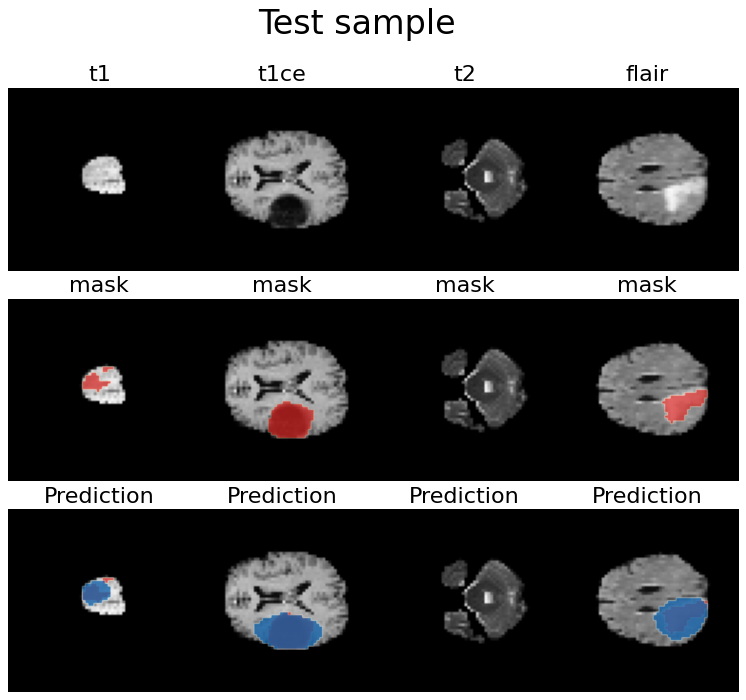

In [ ]:
plot_sample(gen_val, array_labels, model=generator, threshold=0.5, save=False, title=f"Test sample")

In [16]:
testing_loss = []
for idx, (inputs,mask) in enumerate(gen_test): # Add the additional inputs inside the brackets
    mn = np.max(unet.monte_carlo_model.predict(inputs), axis=(1, 2, 3))
    testing_loss.extend(mn)
plt.hist(testing_loss, edgecolor='black', linewidth=1.2, bins=50)

# NOTE: Only evaluate the testing set, when you are not changing the code anymore.
# NOTE: How different is the performance on the validation and testing sets?
# NOTE: Do your results speak of overfitting? Underfitting?
# NOTE: This code evaluates the uncertainty maps. 
# NOTE: Explore the histogram, and investigate why some data samples might have larger uncertainties

AttributeError: 'Functional' object has no attribute 'monte_carlo_model'

In [17]:
dir(unet)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_check_sample_weight_warning',
 '_checkpoint',
 '_checkpoint_dependencies',
 '

In [ ]:
def analyze_data(data:DataGenerator):
    all_inputs = []
    all_masks = []
    for idx, (inputs, mask) in enumerate(data): # Add the additional inputs inside the brackets
        all_inputs.append(inputs)
        all_masks.append(mask)
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    return all_inputs, all_masks
all_train, all_train_masks = analyze_data(gen_train)
all_val, all_val_masks = analyze_data(gen_val)
all_test, all_test_masks = analyze_data(gen_test)

/tmp/ipykernel_4425/730934060.py:65: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
/tmp/ipykernel_4425/730934060.py:65: RuntimeWarning: invalid value encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


In [ ]:
def show_analysis(all_data:np.ndarray, all_masks:np.ndarray, title:str):
    mean_data_img = np.mean(all_train, axis=(0))
    n_channels = mean_data_img.shape[-1]
    mean_masks_img = np.mean(all_masks, axis=(0))
    mean_data = np.mean(all_train, axis=(0, 1, 2))
    mean_mask = float(np.mean(all_masks, axis=(0, 1, 2)))
    std_data_img = np.std(all_train, axis=(0))
    std_masks_img = np.std(all_masks, axis=(0))
    std_data = np.std(all_train, axis=(0, 1, 2))
    std_mask = float(np.std(all_masks, axis=(0, 1, 2)))

    print(f"Mean inputs:")
    for channel in range(n_channels):
        print(f"Channel {channel}: {mean_data[channel]:.2e} +- {std_data[channel]:.2e}")
    print(f"Mean of {title} mask: {mean_mask:.2e} +- {std_mask:.2e}")
    fig, axs = plt.subplots(2, n_channels, figsize=(16, 8))
    fig.suptitle(f"{title} - inputs", fontsize=30)
    for i in range(n_channels):
        
        axs[0,i].imshow(mean_data_img[..., i], cmap='gray', vmin=0, vmax=1)
        axs[0,i].set_title(f"Mean {title} input", fontsize=20)
        axs[1,i].imshow(std_data_img[..., i], cmap='gray', vmin=0, vmax=1)
        axs[1,i].set_title(f"Std {title} input", fontsize=20)
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    fig.suptitle(f"{title} - masks", fontsize=30)
    axs[0].imshow(mean_masks_img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Mean {title} mask", fontsize=20)
    axs[1].imshow(std_masks_img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Std {title} mask", fontsize=20)
    plt.show()
    return mean_data, mean_mask, std_data, std_mask, mean_data_img, mean_masks_img, std_data_img, std_masks_img
            

Mean inputs:
Channel 0: 1.40e-01 +- 2.51e-01
Channel 1: 8.35e-02 +- 1.57e-01
Channel 2: 8.43e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of training mask: 1.68e-02 +- 1.29e-01


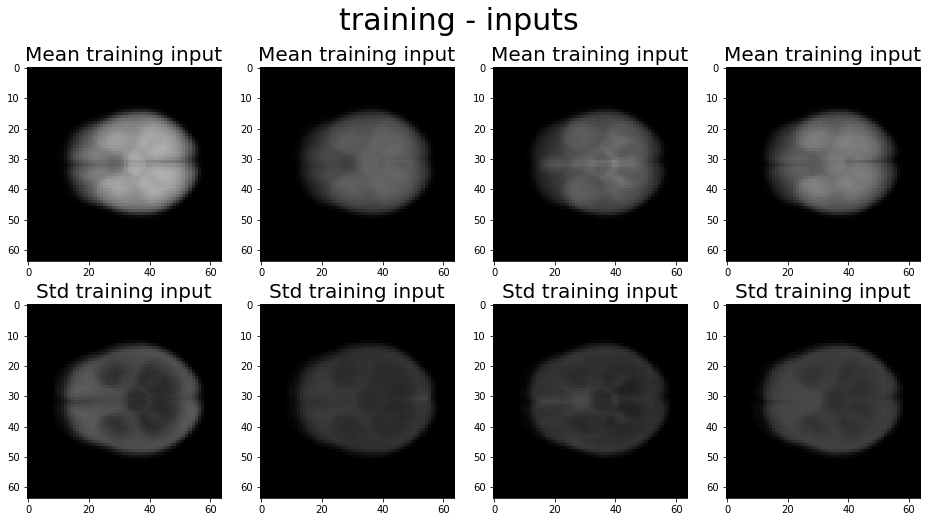

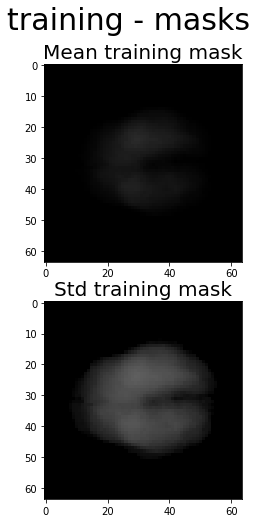

In [ ]:
mean_train, mean_train_mask, std_train, std_train_mask, mean_train_img, mean_train_mask_img, std_train_img, std_train_mask_img = show_analysis(all_train, all_train_masks, "training")

Mean inputs:
Channel 0: 1.40e-01 +- 2.51e-01
Channel 1: 8.35e-02 +- 1.57e-01
Channel 2: 8.43e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of validation mask: 2.04e-02 +- 1.41e-01


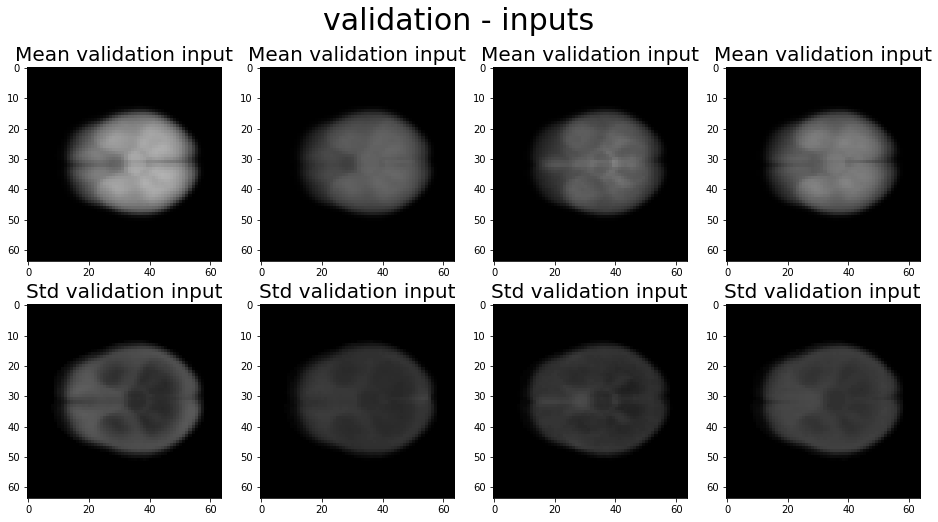

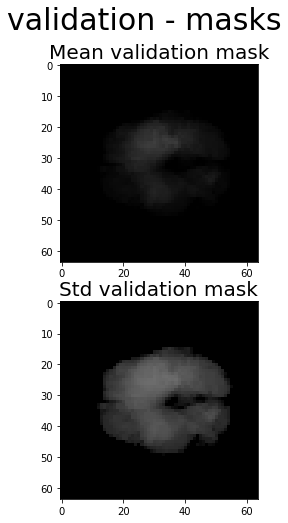

In [ ]:
mean_val, mean_val_mask, std_val, std_val_mask, mean_val_img, mean_val_mask_img, std_val_img, std_val_mask_img = show_analysis(all_val, all_val_masks, "validation")

Mean inputs:
Channel 0: 1.40e-01 +- 2.51e-01
Channel 1: 8.35e-02 +- 1.57e-01
Channel 2: 8.43e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of testing mask: 1.47e-02 +- 1.20e-01


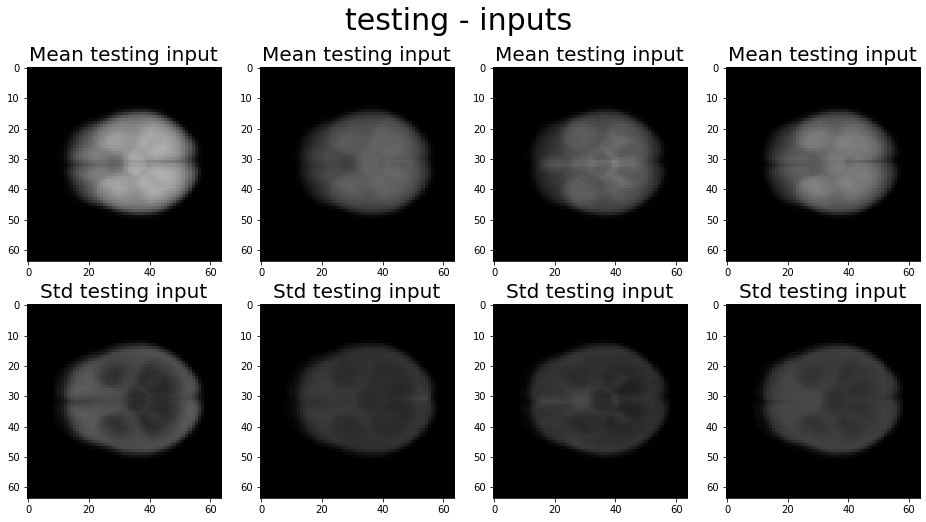

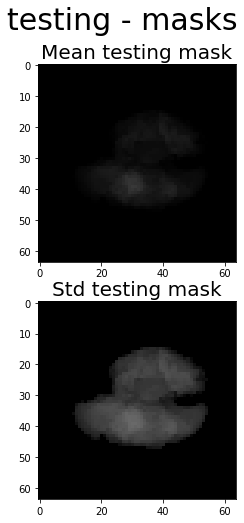

In [ ]:
mean_test, mean_test_mask, std_test, std_test_mask, mean_test_img, mean_test_mask_img, std_test_img, std_test_mask_img = show_analysis(all_test, all_test_masks, "testing")

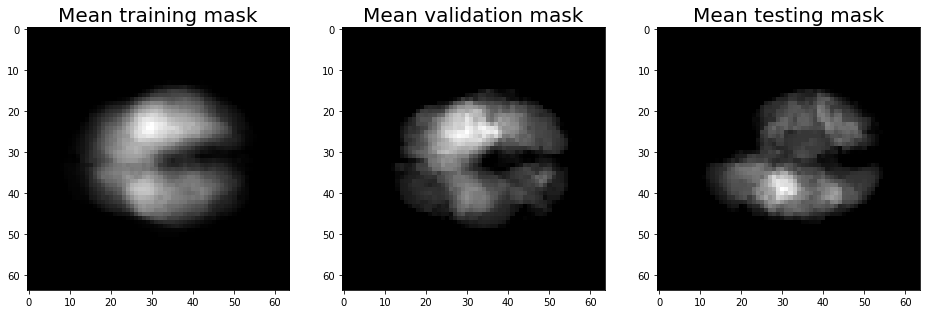

In [ ]:
# Show the mean and std of the masks for the training, validation and testing sets.
fig,axs = plt.subplots(1,3,figsize=(16,8))
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))
axs[0].imshow(normalize(mean_train_mask_img.squeeze()), cmap='gray', vmin=0, vmax=1)
axs[0].set_title(f"Mean training mask", fontsize=20)
axs[1].imshow(normalize(mean_val_mask_img.squeeze()), cmap='gray', vmin=0, vmax=1)
axs[1].set_title(f"Mean validation mask", fontsize=20)
axs[2].imshow(normalize(mean_test_mask_img.squeeze()), cmap='gray', vmin=0, vmax=1)
axs[2].set_title(f"Mean testing mask", fontsize=20)
plt.show()

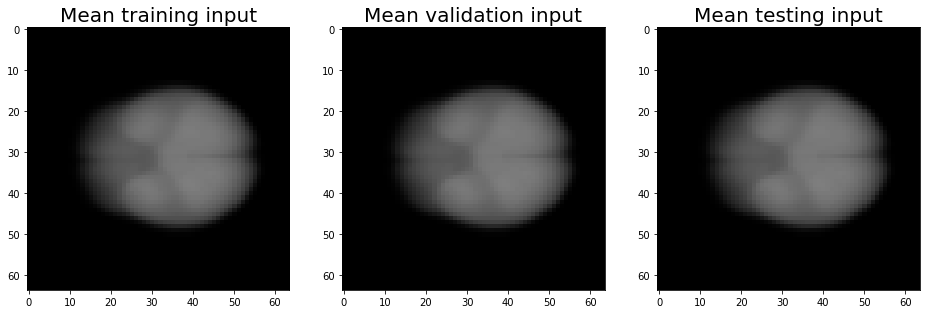

In [ ]:
def compare_inputs(train_img, val_img, test_img):
    train_img = train_img.mean(axis=-1)
    val_img = val_img.mean(axis=-1)
    test_img = test_img.mean(axis=-1)
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    axs[0].imshow(train_img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Mean training input", fontsize=20)
    axs[1].imshow(val_img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Mean validation input", fontsize=20)
    axs[2].imshow(test_img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title(f"Mean testing input", fontsize=20)
    plt.show()
compare_inputs(mean_train_img, mean_val_img, mean_test_img)